# Алешко Альберт Вариант 1 
# Задание 3

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import pearsonr, spearmanr
import pingouin as pg
import tqdm
from statsmodels.formula.api import ols
plt.style.use('Solarize_Light2') # Функция для задания стиля графикам

In [2]:
sheet_name = '2-1'
# sheet_name = '1вар-адекв'
data = pd.read_excel('data2.xlsx', sheet_name=sheet_name, 
                     header=None, names=['var1', 'var2', 'var3', 'var4', 'var5']) # читаем из файла все выборки 
data# выводим их

,var1,var2,var3,var4,var5
0,13.576533,8.444634,42.737,7.574,2.369
1,9.988142,13.552947,23.261,1.660,6.072
2,8.190783,14.466266,13.439,-5.422,3.504
3,8.412009,10.531638,15.174,-5.483,4.532
4,10.021344,8.826599,24.573,3.247,7.447
5,6.843471,7.619135,13.896,-5.045,7.473
6,12.588240,9.044741,31.656,4.941,3.230
7,5.860016,6.764138,9.851,-9.953,6.228
8,11.176900,10.191905,29.845,0.698,1.476
9,12.874558,10.269014,36.838,-1.033,-4.573


In [3]:
length = len(data.T)

In [4]:
def get_correlation(df, corr_func):
    names = df.columns
    correlation = np.zeros((length, length))
    correlation[range(length), range(length)] = 1
    p_values = np.zeros((length, length))
    p_values[range(length), range(length)] = 1

    for i in range(len(names)):
        for j in range(i + 1, len(names)):
            res = corr_func(df[names[i]], df[names[j]])
            correlation[i, j] = correlation[j, i] = res[0]
            p_values[i, j] = p_values[j, i] = res[1]
    df_correlation = pd.DataFrame(correlation)
    df_p_values = pd.DataFrame(p_values)
    df_correlation.columns = df_p_values.columns = names
    df_correlation.index = df_p_values.index = names
    
    return df_correlation, df_p_values

In [5]:
corr, p_vals = get_correlation(data, pearsonr)

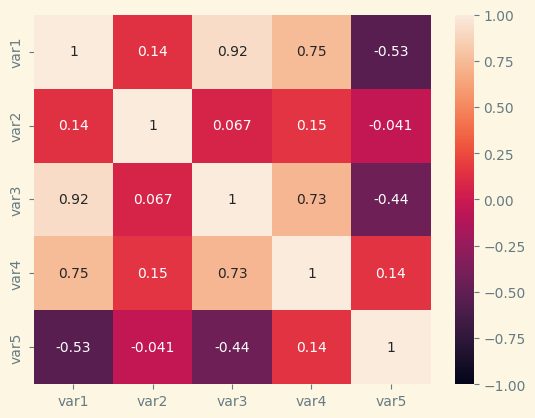

In [6]:
sns.heatmap(corr, annot=True, vmin=-1, vmax=1);

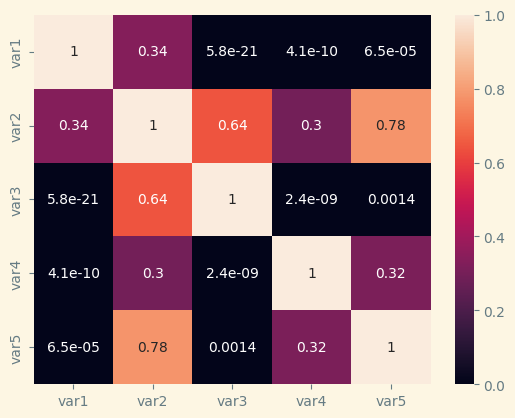

In [7]:
sns.heatmap(p_vals, annot=True, vmin=0, vmax=1);

In [8]:
def get_part_corr(df):
    names = df.columns
    correlation = np.zeros((length, length))
    correlation[range(length), range(length)] = 1
    p_values = np.zeros((length, length))
    p_values[range(length), range(length)] = 1

    for i in range(len(names)):
        for j in range(i+1, len(names)):
            co_names = list(df.columns)
            co_names.remove(names[i])
            if names[j] in co_names:
                co_names.remove(names[j])
            # print((names[i],names[j]),co_names)
            res = pg.partial_corr(data=df, x=names[i], y=names[j], covar=co_names)
            correlation[i, j] = correlation[j, i] = res['r'].iloc[0]
            p_values[i, j] = p_values[j, i] = res['p-val'].iloc[0]
    df_correlation = pd.DataFrame(correlation)
    df_p_values = pd.DataFrame(p_values)
    df_correlation.columns = df_p_values.columns = names
    df_correlation.index = df_p_values.index = names
    
    return df_correlation, df_p_values

In [9]:
# partial_corr = pg.partial_corr(data=data, x='1', y='2', covar=['3','4','5'])
corr_part, p_vals = get_part_corr(data)
# print(partial_corr)

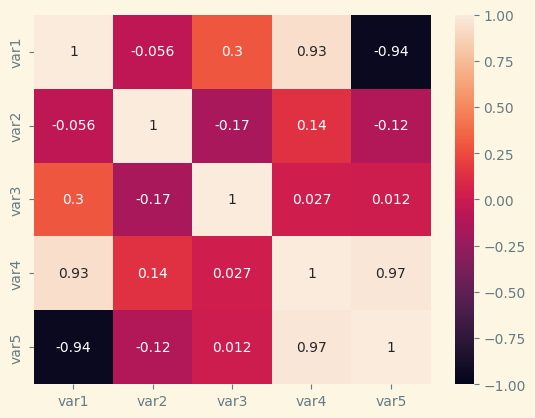

In [11]:
sns.heatmap(corr_part, annot=True, vmin=-1, vmax=1);

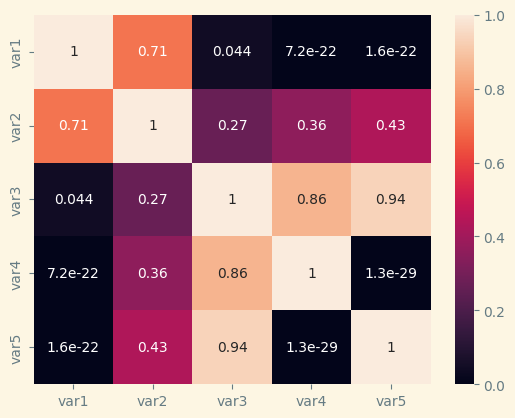

In [12]:
sns.heatmap(p_vals, annot=True, vmin=0, vmax=1);

In [13]:
def multiple_correlation(df):
    names = df.columns
    length = len(names)
    correlation = np.zeros((length))
    p_values = np.zeros((length))
    
    for i, name in enumerate(names):
        formula = name + ' ~ ' + ' + '.join([n for j, n in enumerate(names) if j != i])
        mod = ols(formula=formula, data=df)
        res = mod.fit()
        correlation[i] = res.rsquared ** 0.5
        p_values[i] = res.f_pvalue
    
    return correlation, p_values

In [14]:
corr, p_vals = multiple_correlation(data)

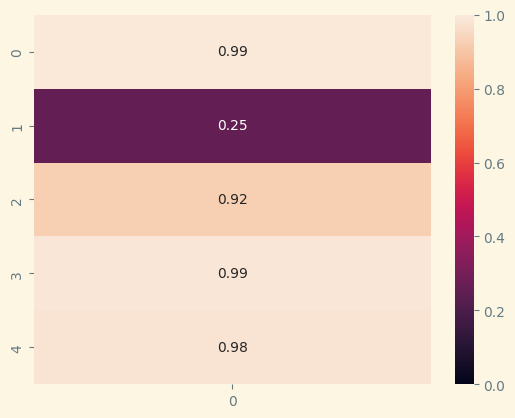

In [15]:
sns.heatmap(corr[..., None], annot=True, vmin=0, vmax=1);

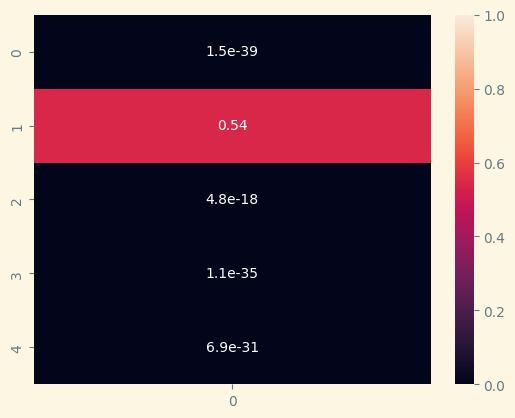

In [16]:
sns.heatmap(p_vals[..., None], annot=True, vmin=0, vmax=1);

In [17]:
corr, p_vals = get_correlation(data, spearmanr)

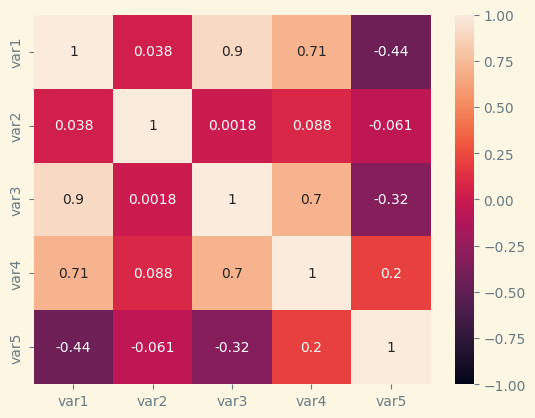

In [18]:
sns.heatmap(corr, annot=True, vmin=-1, vmax=1);

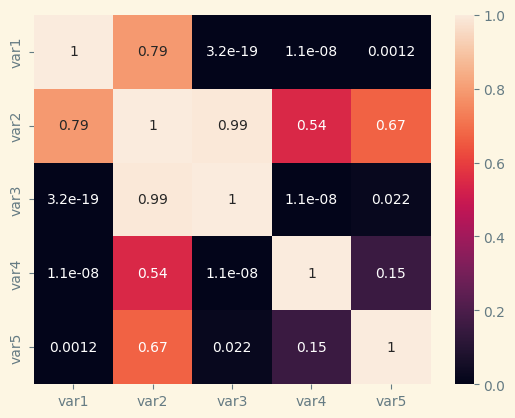

In [19]:
sns.heatmap(p_vals, annot=True, vmin=0, vmax=1);